## Import Libraries and Datasets

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.preprocessing as skpre
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time

In [2]:
# Load in the persons PUMS dataset for WA state
h_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_h53.csv")

## Choose PUMS and Preprocess

In [3]:
# Filter to desired variables (numeric then categorical)
pums_data = h_df[['HINCP','NP','VEH']]

# Remove NA values and check n before/after
print(f"Dataset n={len(pums_data)} pre-cleaning")
pums_data = pums_data.dropna()
print(f"Dataset n={len(pums_data)} post-cleaning")

Dataset n=164836 pre-cleaning
Dataset n=140586 post-cleaning


In [4]:
CAT_IDX = 1
VAR_DIM = pums_data.shape[1]
VAR_NAMES = pums_data.columns

# Split categorical data into OHE vars, save num classes per variable
dummies_list = []
for x in range(CAT_IDX, VAR_DIM):
    dummies = pums_data.iloc[:,x]
    dummies = pd.get_dummies(dummies, prefix=f"{pums_data.columns[x]}_")
    dummies_list.append(dummies)
CAT_LENGTHS = [x.shape[1] for x in dummies_list]

In [5]:
# Final data frame after encoding OHE
model_data_df = pums_data.iloc[:,:CAT_IDX]
for ohe_var in dummies_list:
    model_data_df = pd.concat([model_data_df, ohe_var], axis=1)
MANIFEST_DIM = model_data_df.shape[1]

# Preview data that will be fed into model
model_data_df

,HINCP,NP__1,NP__2,NP__3,NP__4,NP__5,NP__6,NP__7,NP__8,NP__9,...,NP__16,NP__19,NP__20,VEH__0.0,VEH__1.0,VEH__2.0,VEH__3.0,VEH__4.0,VEH__5.0,VEH__6.0
0,102200.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,69360.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,210500.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,50310.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,31200.0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161771,141370.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
161772,60000.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
161774,55000.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
161775,102000.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [6]:
# Separate into train/test data
model_data = model_data_df.values
train_idx = round(len(model_data)*.9)
train_data = model_data[0:train_idx,:]
test_data = model_data[train_idx:len(model_data),:]

# Standardize the input data from -1 to 1 for numerical variables
scaler_train = skpre.StandardScaler()
scaler_test = skpre.StandardScaler()

# Separate the scaling for train/test so that no overall mean/std info is carried
train_data[:,:CAT_IDX] = scaler_train.fit_transform(train_data[:,:CAT_IDX])
test_data[:,:CAT_IDX] = scaler_test.fit_transform(test_data[:,:CAT_IDX])

# Remove rows with numerical outliers (3 < standard deviations)
outlier_row_indices = np.where(np.any(train_data[:,:CAT_IDX] > 3, axis=1))
train_data = np.delete(train_data, (outlier_row_indices), axis=0)
outlier_row_indices = np.where(np.any(test_data[:,:CAT_IDX] > 3, axis=1))
test_data = np.delete(test_data, (outlier_row_indices), axis=0)

## Set Parameters and Define Model

In [7]:
# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 20
LEARN_RATE = 0.001
RHO = 0.9
LATENT_DIM = 2
HIDDEN_DIM = 100
KL_WEIGHT = 0.5

In [8]:
# A layer that takes mean/variance as inputs and returns a random sample z
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(z_log_var) * epsilon

In [9]:
# Encoder
encoder_inputs = keras.Input(shape=(MANIFEST_DIM,))
encoder_x = layers.Dense(HIDDEN_DIM, activation="tanh")(encoder_inputs)
encoder_x = layers.Dense(HIDDEN_DIM, activation="tanh")(encoder_x)
z_mean = layers.Dense(LATENT_DIM, name="z_mean")(encoder_x)
z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(encoder_x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 26)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          2700        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          10100       dense[0][0]                      
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            202         dense_1[0][0]                    
____________________________________________________________________________________________

In [10]:
# Decoder
decoder_inputs = keras.Input(shape=(LATENT_DIM,))
decoder_x = layers.Dense(HIDDEN_DIM, activation="tanh")(decoder_inputs)
decoder_x = layers.Dense(HIDDEN_DIM, activation="tanh")(decoder_x)
decoder_num_outputs = layers.Dense(CAT_IDX, activation="linear")(decoder_x)
decoder_cat_outputs = []
for var_length in CAT_LENGTHS:
    layer = layers.Dense(var_length, activation="softmax")(decoder_x)
    decoder_cat_outputs.append(layer)
decoder = keras.Model(decoder_inputs, [decoder_num_outputs, decoder_cat_outputs], name="decoder")
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 100)          300         input_2[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 100)          10100       dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 1)            101         dense_3[0][0]                    
____________________________________________________________________________________________

In [11]:
# Define custom loss function for combined numerical and categorical data
def get_reconstruction_loss(data, reconstruction, CAT_IDX, CAT_LENGTHS):
    # Handle case with no categorical variables
    if len(CAT_LENGTHS) > 0:
        reconstruction_num = reconstruction[0]
    else:
        reconstruction_num = reconstruction

    # Mean squared error for numerical variables
    data_num = data[:,:CAT_IDX]
    loss_num = keras.losses.mean_squared_error(data_num, reconstruction_num)
    loss_num = tf.reduce_mean(loss_num)
    
    # Categorical cross entropy for categorical variables
    loss_list = []
    current = CAT_IDX
    for i, x in enumerate(CAT_LENGTHS):
        data_cat = data[:,current:(current + x)]
        reconstruction_cat = reconstruction[1][i]
        loss = keras.losses.categorical_crossentropy(data_cat, reconstruction_cat, from_logits=False)
        loss = tf.reduce_mean(loss)
        loss_list.append(loss)
        current += x
    loss_cat = tf.reduce_sum(loss_list)

    # Return both losses; they are combined in the model
    return (loss_num, loss_cat)

def get_kl_loss(z_mean, z_log_var):
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = tf.reduce_mean(kl_loss)
    kl_loss = -kl_loss
    return kl_loss

In [12]:
# Loss metric recorder
loss_tracker = keras.metrics.Mean(name="loss")

# Variational Autoencoder
class VAE(keras.Model):
    def __init__(self, encoder, decoder, CAT_IDX, CAT_LENGTHS, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.CAT_IDX = CAT_IDX
        self.CAT_LENGTHS = CAT_LENGTHS

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            # Get latent vars from the encoder; feed to decoder and get sampled manifest variables
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)

            # Get loss between input values and reconstruction
            reconstruction_loss_num, reconstruction_loss_cat = get_reconstruction_loss(
                data,
                reconstruction,
                self.CAT_IDX,
                self.CAT_LENGTHS
            )
            reconstruction_loss = tf.add(reconstruction_loss_num, reconstruction_loss_cat)

            # Get Kullback Leidler loss between normal distribution and actual for latent variables
            kl_loss = get_kl_loss(z_mean, z_log_var)
            kl_loss = kl_loss * KL_WEIGHT

            # Combine into single loss term
            total_loss = reconstruction_loss + kl_loss

        # Get new gradients given the loss and take another step (update weights)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Record the loss metrics
        loss_tracker.update_state(total_loss)

        return {
            "total_loss": loss_tracker.result(),
            "reconstruction_loss": reconstruction_loss,
            "reconstruction_loss_num": reconstruction_loss_num,
            "reconstruction_loss_cat": reconstruction_loss_cat,
            "kl_loss": kl_loss,
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

    @property
    def metrics(self):
        return [loss_tracker]

## Training

In [ ]:
start_time = time.time()

In [13]:
# Train
vae = VAE(encoder, decoder, CAT_IDX, CAT_LENGTHS)
vae.compile(optimizer=keras.optimizers.RMSprop(learning_rate=LEARN_RATE, rho=RHO))
history = vae.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/20
1548/1548 [==============================] - 3s 2ms/step - total_loss: 2.3688 - reconstruction_loss: 1.1584 - reconstruction_loss_num: 0.3743 - reconstruction_loss_cat: 0.7841 - kl_loss: 0.7474 - val_loss: 0.0000e+00
Epoch 2/20
1548/1548 [==============================] - 3s 2ms/step - total_loss: 1.4952 - reconstruction_loss: 0.5796 - reconstruction_loss_num: 0.2642 - reconstruction_loss_cat: 0.3154 - kl_loss: 0.8870 - val_loss: 0.0000e+00
Epoch 3/20
1548/1548 [==============================] - 3s 2ms/step - total_loss: 1.3950 - reconstruction_loss: 0.4573 - reconstruction_loss_num: 0.2229 - reconstruction_loss_cat: 0.2344 - kl_loss: 0.9212 - val_loss: 0.0000e+00
Epoch 4/20
1548/1548 [==============================] - 3s 2ms/step - total_loss: 1.3474 - reconstruction_loss: 0.3987 - reconstruction_loss_num: 0.1940 - reconstruction_loss_cat: 0.2047 - kl_loss: 0.9361 - val_loss: 0.0000e+00
Epoch 5/20
1548/1548 [==============================] - 3s 2ms/step - total_loss: 1.3125

In [ ]:
print(f"--- {time.time() - start_time} seconds ---")

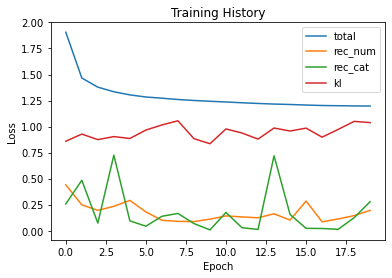

In [14]:
# Plot model loss/training progress
plt.plot(history.history['total_loss'])
plt.plot(history.history['reconstruction_loss_num'])
plt.plot(history.history['reconstruction_loss_cat'])
plt.plot(history.history['kl_loss'])
plt.title("Training History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["total","rec_num","rec_cat","kl"], loc="upper right")
plt.show()

## Testing

Latent Variable: 0
Mean: 0.008724731393158436
Variance: 1.0934224128723145



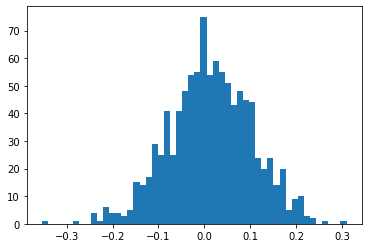

Latent Variable: 1
Mean: -0.026078270748257637
Variance: 1.128958821296692



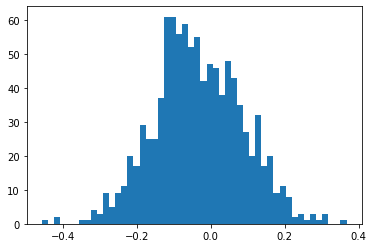

In [15]:
# Get latent vars from the encoder; feed to decoder and get sampled manifest variables
z_mean, z_logvar, z = vae.encoder.predict(test_data[:,:MANIFEST_DIM])

# Record the posterior trained distributions for z
latent_means = []
latent_vars = []

# Determine the average values for the mean/logvariance of the latent variables
for i in range(0, LATENT_DIM):
    epsilon = np.random.normal(loc=0, scale=1, size=1000)
    avg_mean = np.mean(z_mean[:,i])
    latent_means.append(avg_mean)
    avg_var = np.exp(np.mean(z_logvar[:,i]))
    latent_vars.append(avg_var)
    print(f"Latent Variable: {i}")
    print(f"Mean: {avg_mean}")
    print(f"Variance: {np.exp(avg_var)}\n")
    samples = avg_mean + (avg_var * epsilon)
    plt.hist(samples, bins=50)
    plt.show()

In [16]:
# Draw predictions from test data
results = vae.predict(test_data)
loss_num, loss_cat = get_reconstruction_loss(test_data, results, CAT_IDX, CAT_LENGTHS)
print(f"Numerical Variable Loss: {loss_num}")
print(f"Categorical Variable Loss: {loss_cat}")

Numerical Variable Loss: 0.1276688426733017
Categorical Variable Loss: 0.14587625861167908


In [17]:
# Transform continuous/categorical variables back to real values in the results and test data
if len(CAT_LENGTHS) > 0:  
    # Handle case where are categorical variables
    results_num = scaler_test.inverse_transform(results[0])
    test_data_num = scaler_test.inverse_transform(test_data[:,:CAT_IDX])
    results_df = pd.DataFrame(results_num)
    test_data_df = pd.DataFrame(test_data_num)

    # Argmax for each categorical variable the results data
    for x in results[1]:
        result = np.argmax(x, axis=1) + 1
        results_df[f"{x}"] = result
    current = CAT_IDX

    # Argmax for each categorical variable the test data
    for x in CAT_LENGTHS:
        test_data_cat = test_data[:,current:(current + x)]
        test_data_cat = np.argmax(test_data_cat, axis=1) + 1
        test_data_df[f"{x}"] = test_data_cat
        current += x
else:
    # Handle case where there are no categorical variables
    results_num = scaler_test.inverse_transform(results)
    test_data_num = scaler_test.inverse_transform(test_data[:,:CAT_IDX])
    results_df = pd.DataFrame(results_num)
    test_data_df = pd.DataFrame(test_data_num)

# Add back original variables names to the results
results_df.columns = VAR_NAMES
test_data_df.columns = VAR_NAMES

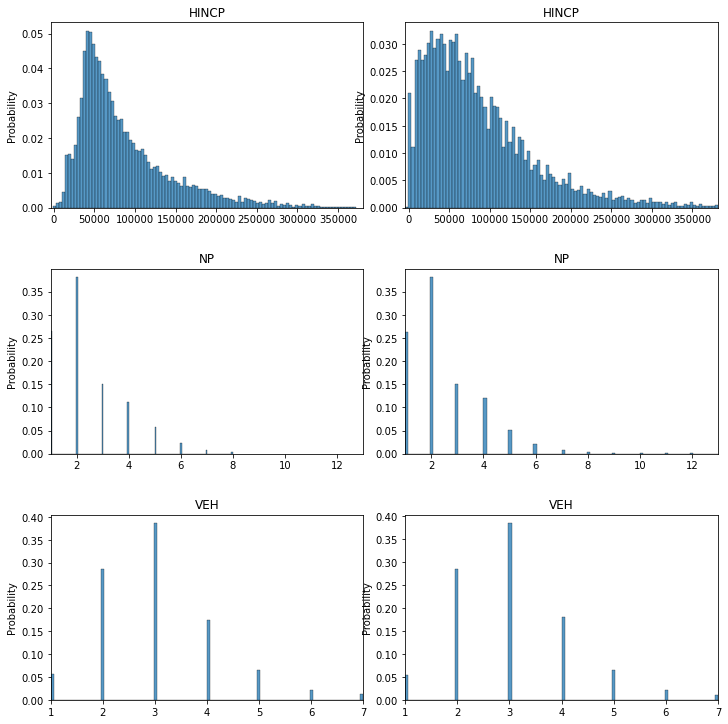

In [18]:
# Show distributions of the resulting variables
fig, axes = plt.subplots(nrows=len(VAR_NAMES), ncols=2, figsize=(10,10))
fig.tight_layout(h_pad=4)

for i, col in enumerate(VAR_NAMES):
    sns.histplot(results_df[col], ax=axes[i,0], stat='probability', bins=100).set(xlim=(min(test_data_df[col]),max(test_data_df[col])))
    axes[i,0].set_title(col)
    axes[i,0].set_xlabel(None)
    sns.histplot(test_data_df[col], ax=axes[i,1], stat='probability', bins=100).set(xlim=(min(test_data_df[col]),max(test_data_df[col])))
    axes[i,1].set_title(col)
    axes[i,1].set_xlabel(None)

## Generating Synthetic Population

In [19]:
start_time = time.time()

In [20]:
# How many synthetic households to generate
POP_SIZE = 2848396  # Number of hh in WA

# Generate random normal sample to represent each latent variable, for each row (different hh per row)
inputs = np.random.normal(loc=0, scale=1, size=(POP_SIZE, LATENT_DIM))

# Generate households; each hh has unique latent input
results = vae.decoder.predict(inputs)

In [21]:
print(f"--- {time.time() - start_time} seconds ---")

--- 62.191200971603394 seconds ---


In [22]:
# Transform continuous/categorical variables back to real values in the results and test data
if len(CAT_LENGTHS) > 0:  
    # Handle case where are categorical variables
    results_num = scaler_test.inverse_transform(results[0])
    test_data_num = scaler_test.inverse_transform(test_data[:,:CAT_IDX])
    results_df = pd.DataFrame(results_num)
    test_data_df = pd.DataFrame(test_data_num)

    # Argmax for each categorical variable the results data
    for x in results[1]:
        result = np.argmax(x, axis=1) + 1
        results_df[f"{x}"] = result
    current = CAT_IDX

    # Argmax for each categorical variable the test data
    for x in CAT_LENGTHS:
        test_data_cat = test_data[:,current:(current + x)]
        test_data_cat = np.argmax(test_data_cat, axis=1) + 1
        test_data_df[f"{x}"] = test_data_cat
        current += x
else:
    # Handle case where there are no categorical variables
    results_num = scaler_test.inverse_transform(results)
    test_data_num = scaler_test.inverse_transform(test_data[:,:CAT_IDX])
    results_df = pd.DataFrame(results_num)
    test_data_df = pd.DataFrame(test_data_num)

# Add back original variables names to the results
results_df.columns = VAR_NAMES
test_data_df.columns = VAR_NAMES

In [23]:
# Transform numeric results back to real variable values
results_num = scaler_test.inverse_transform(results[0])
results_df = pd.DataFrame(results_num)

# Transform categorical results back to real variable values
for x in results[1]:
    result = np.argmax(x, axis=1) + 1
    results_df[f"{x}"] = result

# Add back original variables names to the results
results_df.columns = VAR_NAMES

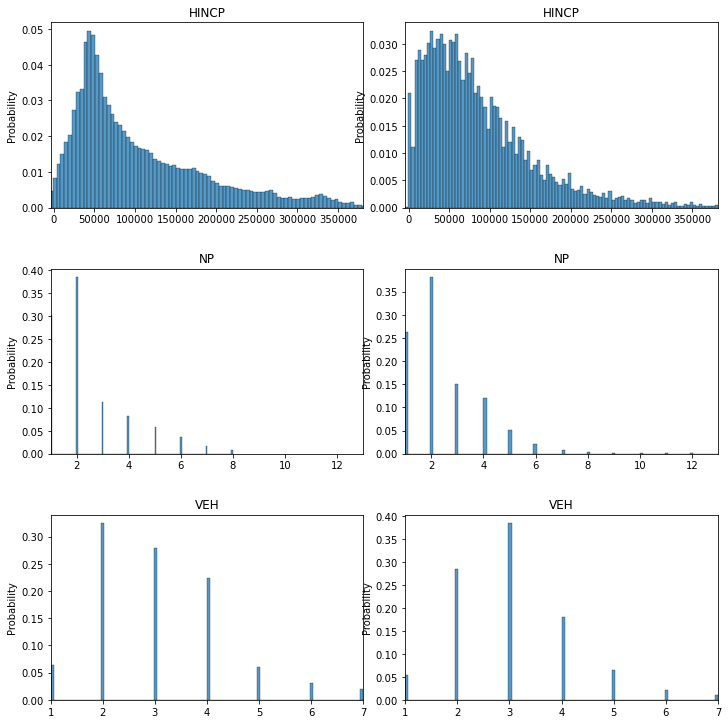

In [24]:
# Show distributions of the resulting variables
fig, axes = plt.subplots(nrows=len(VAR_NAMES), ncols=2, figsize=(10,10))
fig.tight_layout(h_pad=4)

for i, col in enumerate(VAR_NAMES):
    sns.histplot(results_df[col], ax=axes[i,0], stat='probability', bins=100).set(xlim=(min(test_data_df[col]),max(test_data_df[col])))
    axes[i,0].set_title(col)
    axes[i,0].set_xlabel(None)
    sns.histplot(test_data_df[col], ax=axes[i,1], stat='probability', bins=100).set(xlim=(min(test_data_df[col]),max(test_data_df[col])))
    axes[i,1].set_title(col)
    axes[i,1].set_xlabel(None)

In [25]:
# Save the synthesized households
results_df.to_csv('data/synthetic_populations/wa_households.csv', index=False)
results_df

,HINCP,NP,VEH
0,106632.039062,3,3
1,42727.421875,1,2
2,124290.382812,2,2
3,118212.500000,2,2
4,32028.931641,1,2
...,...,...,...
2848391,47937.195312,2,4
2848392,201792.843750,2,4
2848393,54963.812500,4,3
2848394,208234.546875,3,3
